In [4]:
#importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sqlite3
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

import gensim

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


In [5]:
#read the dataset
conn=sqlite3.connect('final.sqlite')
final=pd.read_sql_query("""select * from Reviews""",conn)
conn.close()
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedNoStem,CleanedSummary
0,540125,B002W08W56,A2STPOZAT37RNE,Betty Baker,1,1,1,1300320000,"Wonderful, but surprised to find this size can...",Great beans....the best texture hands down. T...,great bean best textur hand seem great tast do...,great beans best texture hands seem great tast...,wonderful surprised find size
1,31763,B000UXWQMC,A115Y8R40DCT3I,Guy,0,0,1,1345161600,better than expected,I usually buy whole pitted olives and when I b...,usual buy whole pit oliv bought good wasnt who...,usually buy whole pitted olives bought good wa...,better expected
2,509504,B000P09RJA,A2BR8LGC8N6XQD,dj2u,0,4,0,1278374400,Wrong size bars sent,The first shipment was just as ordered. This ...,first shipment order last shipment not bar wen...,first shipment ordered last shipment not bars ...,wrong size bars sent
3,27728,B000K8ESBY,A1RYTIMIWPDJ4O,"Bill Ison ""Bill""",0,0,1,1256169600,Coffee flavoring,"<a href=""http://www.amazon.com/gp/product/B000...",flavour creation coffe flavor tablet french va...,flavour creations coffee flavoring tablets fre...,coffee flavoring
4,128657,B001AVJT0K,AJ6SZ4YAPOOO7,Mwebi,0,0,1,1348099200,They all come running,"I have the pickiest cats, they hate 99/100 kin...",pickiest cat hate kind food better vari otherw...,pickiest cats hate kinds food better vary othe...,come running


In [6]:
#Creating a new balanced dataframe 
negative=final[final['Score']==0][['Score','Time','CleanedSummary','CleanedText']]
positive=final[final['Score']==1][['Score','Time','CleanedSummary','CleanedText']]
data=pd.concat([negative,positive.iloc[:65000,:]],axis=0,ignore_index=True)#concatenation
data.sort_values('Time',inplace=True)#sorting on time

In [7]:
data.head()

,Score,Time,CleanedSummary,CleanedText
89279,1,944092800,entertainingl funny,beetlejuic well written movi everyth excel act...
99092,1,944438400,modern day fairy tale,twist rumplestiskin captur film star michael k...
21840,0,948240000,clamshell edition edited version,alway enjoy movi funni entertain didnt hesit p...
114632,1,951523200,bettlejuice bettlejuice bettlejuice,happen say name three time michael keaten star...
113134,1,961718400,great product,realli good idea final product outstand use de...


**Binary BOW model on review text**

In [8]:
bow_vect=CountVectorizer(binary=True) #initializing the binary countvectorizer 
bow=bow_vect.fit_transform(data['CleanedText'].values)

In [9]:
x=bow  #if x is sparse matricsthan do not convert it into numpy array
y=data['Score'].values

In [10]:
#train test split 
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,shuffle=False)

* Code to perform k fold

the optimal value of alpha is 0.400000


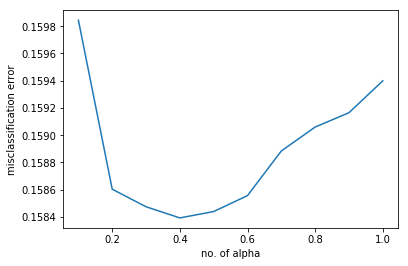

In [13]:
alpha=np.linspace(0.1,1,10)
cv_scores=[]

for a in alpha:
    clf=BernoulliNB(alpha=a)
    score=cross_val_score(clf,x_train,y_train,cv=10,scoring='accuracy') #Hyper parameter -CV
    cv_scores.append(score.mean())
    
MSE=[1-x for x in cv_scores]

optimal_alpha=alpha[MSE.index(min(MSE))]
print('the optimal value of alpha is %f' % optimal_alpha)
plt.plot(alpha,MSE)
plt.xlabel('no. of alpha')
plt.ylabel('misclassification error')
plt.show()

In [16]:
#fitting the model on optimal value of k
clf=BernoulliNB(alpha=optimal_alpha)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test) #generating prediction
acc=accuracy_score(y_test,y_pred,normalize=True)*float(100)
print(acc)
confusion_matrix(y_test,y_pred).T

83.6704610597


array([[14623,  2343],
       [ 3639, 16028]], dtype=int64)

* Extracting imp. features of both the classes from the model

In [21]:
idx=(-clf.feature_log_prob_).argsort()[:2,:50]
print('top 50 words in negative reviews')
for i in idx[0]:
    print(bow_vect.get_feature_names()[i])
    
print("\n**********************************************\n")
print("top 50 words in positive reviews")
for i in idx[1]:
    print(bow_vect.get_feature_names()[i])

top 50 words in negative reviews
not
tast
like
product
one
would
tri
flavor
good
buy
get
use
dont
even
order
much
make
realli
time
amazon
love
look
eat
box
disappoint
bought
food
purchas
review
first
better
packag
want
bad
think
coffe
also
bag
could
know
say
well
great
didnt
thought
price
give
made
way
got

**********************************************

top 50 words in positive reviews
not
like
tast
love
good
great
flavor
one
use
tri
product
make
get
time
buy
would
realli
amazon
find
best
also
much
price
eat
littl
dont
store
well
order
food
even
coffe
ive
better
recommend
year
tea
day
found
high
drink
sweet
mix
bag
give
delici
first
enjoy
want
favorit
